In [2]:
#| code-fold: true

import numpy as np
import scipy.stats
import scipy.linalg

import matplotlib.pyplot as plt

from functools import reduce

import pyqsp
import pyqsp.angle_sequence
import pyqsp.response

from pyqsp.angle_sequence import QuantumSignalProcessingPhases

import contextlib
import io

def quiet(func):
    def quiet_func(*args, **kwargs):    
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            res = func(*args, **kwargs)
        return res
    return quiet_func

plt.rcParams["figure.figsize"] = (6, 4)

# Introduction

@ArazzolaQSVT @Gilyen2019 @Tang2023 @Martyn2021

Quantum singular value transformation (QSVT) is a new framework developed in recent years that is now extensively used to understand and improve existing as well as construct new quantum algorithms. If you are willing to be bit dramatic, QSVT has been claimed to provide a grand unification of many different quantum algorithms. So, how does it work?

## A high-level overview
Constructing a quantum algorithm using QSVT consists the following main steps. Don't worry if this does not immediately make sense, the goal of this post is to fill in the details and illustrate with examples.

1. Reduce your problem of interest to transforming singular values of some matrix $A$.
2. Find a unitary circuit $U$ that is a block-encoding of your matrix, i.e. in a suitable basis $$U=\begin{pmatrix}A&*\\ *&*\end{pmatrix} \ .$$
3. If the goal is to transform singular values $\sigma_i$ of $A$ by some function $f(\sigma_i)$, find an appropriate polynomial approximation $p(x)\approx f(x)$.
4. Using quantum signal processing construct a circuit $U_\phi$ that involves as much applications of $U$ as the degree of $p(x)$ and block-encodes approximation the answer, i.e.
$$U_\phi=\begin{pmatrix}p(A)&*\\*&*\end{pmatrix}$$
Here $p(A)$ has singular values $p(\sigma_i)$ but we don't yet give its precise definition.

Let's start with clarifying the first step, i.e. how to frame your quantum problem as a singular value transformation, by giving three examples.

1. **Grover's search.** There is some marked state $|m\rangle$ of $n$ qubits that wee need to find. In this case we can take $A$ to be $1\times 1$ matrix containing a single matrix element $a=\langle m|H^{\otimes n}|0\rangle$. If we can apply the step-function to it $x\to \theta(x-b)$, we will map an arbitrary amplitude $a>b$ to 1, and hence build the circuit that is guaranteed to take the initial state $|0\rangle$ to the marked state $|m\rangle$.
1. **Quantum simulation.** Here given a Hamiltonian $H$ we seek to construct a unitary $e^{-iHt}$. This is literally the problem of the eigenvalue transformation, because $e^{-iHt}$ is by definition the matrix $H$ with eigenvalues $\lambda_i$ mapped to $e^{-i\lambda_i t}$. Up to technicalities, eigenvalues can be transformed in the same way as singular values.
1. **Solving linear equations.** Given a matrix $A$ and a vector $b$ solve $Ax=b$ for $x$, i.e. compute $A^+b$ where $A^+$ is Moore-Penrose pseudo-inverse of $A$. But pseudo-inverse $A^+$ is just equal to the usual hermitian conjugate $A^\dagger$ with reciprocal singular values $\sigma_i\to \sigma_i^{-1}$.

Many other applications of QSVT exist, but in this blog post I will focus on these ones. So hopefully step (1) is starting to make sense now. How do we perform step (2) then, how to find the block-encoding? To my understanding, this may be the most challenging step that has to be addressed case-by-case. I will give some intuition and examples of block-encodings below. Next, QSVT allows to directly perform only polynomial transformations, but most problems of practical interest require applying non-polynomial functions to singular values. This is why we need step (3), which is finding the right polynomial approximation. Interestingly, the degree of the approximating polynomial determines the complexity of the final quantum circuit, so this is an important step. Finally, after you found the polynomial transformation approximating your target function you use techniques of the quantum signal processing to prepare the corresponding quantum circuit. Generally, constructing the circuit for a given polynomial is quite under control, although there still may be issues with speed and numerical stability for large instances.

## What I will and will not discuss

...

# Quantum signal processing

The origin and application of the quantum signal processing (QSP) are very interesting in their own right, but I won't review them here. Instead, I will view QSP as a rudimentary version of QSVT applied to two-level systems, and hence it is a great starting point.

## Ingredients
So, suppose you have a two-level system and can perform a simple diagonal transformation on it
\begin{align}
S(\phi)=\begin{pmatrix}e^{i\phi}&0 \\ 0& e^{-i\phi}\end{pmatrix} \ . \label{S}
\end{align}
Here $\phi$ is an angle you can vary. You can also perform a fixed non-diagonal operation
\begin{align}
R(a)=\begin{pmatrix}a&\sqrt{1-a^2}\\\sqrt{1-a^2} & -a\end{pmatrix} \ . \label{R}
\end{align}
Here $a\in \mathbb{R}$ is fixed.


## Circuit
The most general quantum circuit you can build from tese two ingredients is te following alternating sequence

\begin{align}
U_\phi =S(\phi_0)\prod_{i=1}^d R(a) S(\phi_i) = S(\phi_0)R(a) S(\phi_1) R(a)\dots S(\phi_{d-1}) R(a) S(\phi_d) \label{QSP} \ .
\end{align}

Now, if you actually compute $U_\phi$, you'll find it is of the following form (up to a global pase)
$$U_\phi= \begin{pmatrix} P(a) & i Q(a)\sqrt{1-a^2} \\ i Q(a)^*\sqrt{1-a^2} & P(a)^*\end{pmatrix} \ . $$
Importantly, here $P(a)$ and $Q(a)$ are *polynomials*.

:::{.callout-note title='W and R signal conventions' collapse=true}
Our singnal-processing operator is the 'R-convention'. Another standard one is 'Wx-convention' with the signal operator given by
$$W(a)=\begin{pmatrix}a & i\sqrt{1-a^2}\\i\sqrt{1-a^2} & a\end{pmatrix} \ .$$
The two signal operators are related by $R(a)=-i S(\pi/4) W(a) S(\pi/4)$. For the $W$ signal operator relation \eqref{QSP} is exact, while for $R(a)$ there is an additional global phase $i^d$. If we have the angle sequence $\phi_i$ implementing the desired polynomial transformation with $W$-signal, the angles for $R$ signal are 
$$\phi_0^R=\phi_0^W+(2d-1)\frac{\pi}{4}, \phi_d^R=\phi_d^W-\frac{\pi}{4}, \phi_i^R=\phi_i^W-\frac{\pi}{2} (0 < i< d) \ .$$
:::

## Polynomials from QSP

Why are $P(a)$ and $Q(a)$ polynomials? Well, you can check this directly/prove by induction. For instance,
$$\begin{pmatrix} P(a) & i Q(a)\sqrt{1-a^2} \\ i Q(a)^*\sqrt{1-a^2} & P(a)^*\end{pmatrix} \begin{pmatrix} a & i \sqrt{1-a^2} \\ i\sqrt{1-a^2} & a\end{pmatrix}=\begin{pmatrix} P'(a) & i Q'(a)\sqrt{1-a^2} \\ i Q'(a)^*\sqrt{1-a^2} & P'(a)^*\end{pmatrix}$$
with (primes are not derivatives!) 
$$P'(a)=aP(a)-Q(a)(1-a^2),\qquad Q'(a)=P(a)+aQ(a) \ .$$ 

The polynomials $P,Q$ obtained in this way will always satisfy the following three properties.

1. $degree(P)\le d$, $degree(Q)\le d-1$. In words, the degree of $P$ is no more than the number of times $R(a)$ is applied, and degree of $Q$ is one less.
1. $P(-a)=(-1)^{d+1} P(a), Q(-a)=(-1)^{d} Q(a)$. In words, both $P$ and $Q$ have definite and opposite parity. For $d$ even $P$ is odd and $Q$ is even, for $d$ odd $P$ is even and $Q$ is odd.
1. $|P(a)|+(1-a^2)|Q(a)|^2=1$. This follows from $U_\phi$ being a unitary. In particular, this implies that $P(a)$ is bounded $|P(a)|\le 1$ for $-1\le a\le 1$.

An important fact of QSP is that the reverse statement is also true - as long as a degree $d$ polynomial $P$ satisfies these conditions, there is a $d+1$ angles $\phi_i$ that produce $P$ via the QSP \eqref{QSP}. While the proof is not trivial, the statement looks reasonable. Indeed, a complex polynomial $P$ of degree $d$ and definite parity has about $d$ independent real coefficients, and this is the number of angles we can tweak in the QSP.

## Generalizing QSP polynomials
While many polynomials $P$ can be obtained in this way, there some important limitations. In particular, by property (3) $|P(1)|=1$, which is often undesirable. The trick is to look at the real part $\operatorname{Re} P(a)$. While still bounded, it does not have to satisfy $\operatorname{Re} P(1)=1$ and is general enough for many applications. Then the problem is how to access $\operatorname{Re}P$. One way is to measure the QSP operator in $|\pm\rangle$ basis. Indeed, note that

$$
\langle +|U_\phi|+\rangle=\operatorname{Re}P(a)+i\operatorname{Re}Q(a)\sqrt{1-a^2}
$$

A QSP sequence can be found so that $\operatorname{Re}P(a)$ gives our desired polynomial while $\operatorname{Re}Q(a)$ is approximately zero. 

Aonther way to separate the real part of $P(a)$ is by applying the following circuit

![Block encoding real polynomial](figures/uphiuminusphi.svg){#fig-uphi width=400 fig-align='center' }

This way of doing it more readily generalizes to QSVT. In effect, this circuit performs a block-encoding of $\frac12\left(U_\phi+U_{-\phi}\right)$. Note that $U_{-\phi}$ gives rise to $P(a)^*$ and so $\frac12\left(P(a)+P(a)^*\right)$ is the real part of $P$ we are after. If the circuit above is not clear don't worry, I will discuss block encodings in sec.@sec-block.

## Implementation
Let's now implement the QSP and see how it works in practice. First we define the $R$-signal and signal-processing operators. To get QSP sequences we will use `pyqsp` python package @pyqsp. Since it gives anges in the $W$-convention, we will also need to convert them to our $R$ convention. Finally, we define a function that assembles the QSP circuit.

In [3]:
def R(a):
    """Singnal operator in R-convention."""
    
    b = np.sqrt(1-a**2)
    R = np.array([
        [a, b],
        [b, -a]])

    return R

def S(phi):
    """Diagonal signal-processing operator."""
    
    return np.diag([np.exp(1j*phi), np.exp(-1j*phi)])

def angles_from_W_to_R(phis):
    """Convers QSP angles from W convention to R convention."""
    
    assert len(phis)>0, 'At least one angle must be provided.'
    
    phis = \
    [phis[0]+(2*len(phis)-3)*np.pi/4] \
    + [phi-np.pi/2 for phi in phis[1:-1]] \
    + [phis[-1]-np.pi/4]
    
    return phis 

def apply_QSP(R, phis):
    """Computes S(phi_0) @ R @ S(phi_1) @ R ... @ S(phi_d-1) @ R @ S(phi_d). """
        
    res = S(phis[-1])
    for phi in phis[:-1][::-1]:        
        res = S(phi) @ R @ res
    
    return res

Now let's take some arbitrary polynomial $P$, determine the QSP angles $P\to \phi$, and check that the real part of the QSP circuit $U_\phi[0,0]$ reproduces the chosen polynomial.

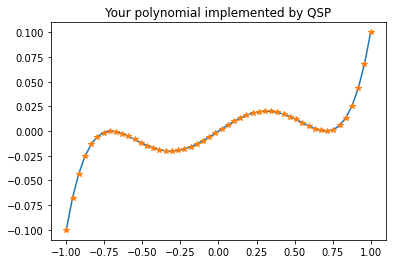

In [124]:
# Note that the polynomial must have definite parity and be bounded.
P = np.polynomial.Polynomial([0., 0.1, 0., -0.4, 0., 0.4]) 

# QSP angles from polynomial coefficients.
phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(P.coef, signal_operator='Wx')
phis = angles_from_W_to_R(phis)

# Range to scan over.
x = np.linspace(-1, 1, 50)

# Compute matrix elements of the QSP sequence
unitaries = [apply_QSP(R(xi), phis) for xi in x]
matrix_elements = [np.real(u[0,0]) for u in unitaries]

# Compare
plt.plot(x, P(x));
plt.plot(x, matrix_elements, '*');
plt.title('Your polynomial implemented by QSP');

If you are running this as an interactive notebook, try changing the polynomial and see what happens.This excersize ends our introduction to QSP.

# Technical background

You may think of QSVT as a generalization of QSP, where instead of applying a polynomial transformation to a single matrix element you apply it the singular values of a block-embedded matrix. Before explaining how exactly does that work we should go thought some mathematical preliminaries.

# Singular value decomposition

## What is it?
Probably it's worth making a brief digression to discuss what are those singular values that we are going to transform. If, like me, you are more familiar with hermitian matrices and eigenvalues, think of the singular values as a generalization.

So, the key theorem known as the singular value decomposition (SVD), says that *any* (and I mean *any*: real or complex, hermitian or non-hermitian, square or rectangular) matrix $A$ can be decomposed as follows
$$A=V\Sigma W^\dagger \ .$$

If $A$ is $n\times m$ matrix then $V$ is a unitary of dimension $n\times n$, $W$ is a unitary of dimension $m\times m$ and $\Sigma$ is something like a diagonal matrix, except it has dimension $n\times m$ and can be non-square. The 'extra' non-square part consists of zeros. If you remove it, $\Sigma$ is just a diagonal matrix with *positive* entries $\sigma_i$. Another way of writing SVD is using bra-ket notation
$$A=\sum_i \sigma_i|v_i\rangle \langle w_i| \ .$$

## Relation to eigenvalues
For Hermitian matrices the eigenvector decomposition is almost the same as SVD with $V=W$. A subtlety is that by definition $\sigma_i\ge0$ while the eigenvalues can be negative. Negative signs of the eigenvalues can be absorbed into $V$ or $W$, but this will make them different.

Also, you can show that non-zero eigenvalues of hermitian operators $A^\dagger A$ and $AA^\dagger$ are equal to the singular values of $A$ squared.

## Relation to operatorn norm
SVD has many applications, and I'll mention two of them that will be relevant. Define the operator norm of $A$ by 
$$||A||=\sup_v \frac{|Av|}{|v|} \ . $$

In words, the linear transformation $A$ in general changes the lenght of the input vector $v$, and the operator norm quantifies the largest such change. It is easy to see that $||A||=max_i \sigma_i$, i.e. that operator norm is equal to the largest singular value.

Operator norm is natural in quantum mechanics and in particular in QSVT. Assume we aimed to implement some operator $A_0$ but only managed to implement $A$. For an arbitrary state we can write $A|\psi\rangle=A_0|\psi\rangle+(A-A_0)|\psi\rangle$. The 'error' term can be bounded as $|(A-A_0)|\psi\rangle|\le ||A-A_0||$. hence, if $A$ is close to $A_0$ in the operator norm, its action on any state will have a large overlap with the target state. In quantum mechanics this means that for all practical purposes $A$ is a good approximation to $A_0$.

## Moore-Penrose pseudo-inverse {#sec-pseudo_inverse}
Another application of SVD is to solving linear systems of equations $Ax=b$. Depending on $A$ and $b$, the system may have a single solution, many solutions or none at all. A related problem is to minimize $|Ax-b|^2$, a problem which always has a solution. It can be written as $x=A^+b$ with $A^+$ being the Moore-Penrose pseudo-inverse. It is most easily defined in terms of the SVD
$$A^+=\sum_{\sigma_i\neq0}\sigma_i^{-1} |w_i\rangle \langle v_i| \ .$$
For invertible matrices $A^+$ conicides with the usual inverse $A^{-1}$ for non-invertible ones, this is in a sense the closest you can get.

## How to define polynomial of an arbitrary matrix
It is straigtforward to define a polynomial of a hermitian matrix, e.g. for $p(x)=x-x^2+x^4$ we set $p(h)=h-h^2+h^4$. Alternatively, we can say that the polynomial applies to eigenvalues of $h$, i.e. if $h=\sum_i \lambda_i |v_i\rangle\langle v_i|$ then $p(h)=\sum_i p(\lambda_i) |v_i\rangle\langle v_i|$.

For a general matrix $A$ expressions like $A^2$ may not make sense, because of incompatible dimensions. More abstractly, for a generic operator $A$ the input space need not be the same as the output space, so applying $A$ twice is simply not defined. In principle, we could still define $p(A)$ by applying $p$ to singular values of $A$, similarly to the hermitian case. The more natural and useful definition is a bit different. For $A=\sum_i \sigma_i|v_i\rangle\langle w_i|$ define
\begin{align}
p(A)=\begin{cases} \sum_i p(\sigma_i)|v_i\rangle \langle w_i|,\qquad \text{$p$ is odd}\\ \sum_i p(\sigma_i)|w_i\rangle \langle w_i|,\qquad \text{$p$ is even} \end{cases}
\end{align}

For example, for $p(x)=1-x^2+x^4$ we get $p(A)=\mathbb{1}-A^\dagger A+(A^\dagger A)^2$, for $p(x)=x-x^3$ we get $p(A)=A-AA^\dagger A$. The pattern should be clear. By alternating $A$ and $A^\dagger$ we make sure that the input space of a new operator is the output space of a preceeding one. If the $p(x)$ is odd, $p(A)$ maps between the same space as $A$. If $p(x)$ is even, $p(A)$ maps the input space of $A$ back to itself.

We will see that this distinction between the even and odd polynomials will spillover into QSVT.

# Block encoding

Another key concept to QSVT is that of block-encoding. The idea is as follows. Quantum computer can only effect unitary transformations $U$. However, many interesting operators are not unitary (say a typical hamiltonian, or a matrix of a linear system). One solution here is block-encoding.

##  Block encoding in the computational basis
The simplest case of the block encoding is when your matrix of interst $A$ occupies the top-left corner of your unitary

$$U=\begin{pmatrix}A& *\\ * & *\end{pmatrix} \ .$$

Here and below, the wildcard asterisk $*$ means that we don't care what is contained in other blocks. $A$ and $*$ blocks can be of any size compatible with one another. $U$ must be square, of course. That's it, that is block-encoding. The tricky part is to actually find an efficient quantum circuit corresponding to $U$. This is heavily problem-specific and I will not go into details, assuming that the block-encoding is given to us (you may say we have an oracular access to it). I will however discuss one particular example, known as the linear combination of unitaries in sec.@sec-LCU.

## Can any matrix be block encoded?
The block encoded matrix $A$ may in principle be arbitrary. The only restriction is that its operator norm is less then one $||A||\le1$ (otherwise $U$ can not be unitary). If this is not the case, we can often encode $A/\alpha$ with sufficiently large $\alpha$ instead. Again, this is very problem-specific.

## Single-qubit block encoding
Often operator $A$ to be block-encoded naturally acts on some $n$-qubit system, perhaps $A$ is it's Hamiltonian. In that case, assuming $||A||\le 1$, we only need one additional qubit to block-encode $A$. The result may look somtheing like

$$U=\begin{pmatrix} A & \sqrt{1-AA^\dagger} \\ \sqrt{1-A^\dagger A} & -A^\dagger \end{pmatrix}\ .$$

:::{.callout-note title="Exercise" collapse=true}
Show that $U$ is untary. You will need to show that $A\sqrt{1-A^\dagger A}=\sqrt{1-AA^\dagger}A$ which can be done via SVD.
:::

Alternatively, we can write $U=|0\rangle\langle0|\otimes A+\dots$. 

## Controlled unitary is a block encoding
For the sake of intuition I will give two example of how the block encoding can be realized with a unitary circuit. One familiar example of a block encoding is a controlled unitary operation. Indeed,
$$C(U)=|0\rangle \langle 0| \otimes U+|1\rangle \langle 1| \otimes U=\begin{pmatrix} U & 0 \\ 0 & \mathbb{1}\end{pmatrix} \ .$$
Note that this is $|0\rangle$-controlled unitary, the standard $|1\rangle$-controlled would have the $U$ and the identity blocks swaped. More generally, let $U$ be controlled by some basis state of $n$ qubits $|m\rangle$, i.e. $C_{|m\rangle\langle m|}U=|m\rangle\langle m| \otimes U+(\mathbb{1}-|m\rangle\langle m|)\otimes\mathbb{1}$. Then, in matrix form

$$C_{|m\rangle\langle m|}U=\begin{pmatrix}\mathbb{1} &&&&\\ &\ddots&&& \\ && U && \\ &&&\ddots& \\ &&&&\mathbb{1}\end{pmatrix} \ ,$$ 

where $U$ occupies $m$-th block.

## Linear combination of unitaries

***Linear combination of unitaries (LCU)*** is a powerful technique for block encoding. Using controlled versions of unitary operators $U_1,\dots, U_N$ it block encodes their linear combination $\alpha_1 U_1+\dots\alpha_N U_N$

It works as follows. Assume $N=2^n$ and you can implement unitaries $U_m$ controlled by a state of $|n\rangle$ qubits, $C_{|m\rangle\langle m|}U_m$. Taking the product of all these controlled unitaries we get what is known as the $\text{SELECT}$ operator

$$\text{SELECT} = \prod_m C_{|m\rangle\langle m|}U_m = \begin{pmatrix}U_1 &&&&\\ &\ddots&&& \\ && U_m && \\ &&&\ddots& \\ &&&&U_{2^n}\end{pmatrix}$$

In other words, $\text{SELECT} = \sum_m |m\rangle\langle m| \otimes U_m$, and it applies (selects) a different unitary based on the value of the control state. Now also assume you have a $\text{PREPARE}$ operator acting on the control qubits as follows $\text{PREPARE} |0\rangle=\sum_m \sqrt{\alpha_m} |m\rangle$ (assuming $\sum_i\alpha_i=1$). Then

$$\text{PREPARE}^\dagger\cdot\text{SELECT}\cdot\text{PREPARE} = \begin{pmatrix}\alpha_1 U_1+\dots \alpha_NU_N& *\\ *&* \end{pmatrix}$$

i.e. it block encodes the desired linear combination. 

:::{.callout-note title="Exercise" collapse=true}
Prove this statement. Show also that See @fig-uphi is a particular case, and that it indeed block encodes $\frac12\left(U_{\phi}+U_{-\phi}\right)$ as claimed.
:::

Note that we need logarithmically less ancilla qubits than the number of unitaries, so the computaions above are efficient. One of the use cases for this protocol is to block encode a local Hamiltonian, i.e. a Hamiltonian that constists of not too many Pauli strings of bounded weight. Implementing the controlled version of each Pauli string is straightforward, and the procedure goes through.

## Applying block-encoded operator to a state
We can apply a block-encoded operator $A$ to a quantum state $|\psi\rangle$ as follows. Assume $U=|0\rangle\langle0|\otimes A+\dots$ block-encodes $A$ and we also have a state of $n+1$ qubit system that looks as follows $|\Psi\rangle=|0\rangle \otimes|\psi\rangle$. Then

$$U|\Psi\rangle = \begin{pmatrix} A & *\\ * & *\end{pmatrix}\begin{pmatrix} |\psi\rangle \\ 0\end{pmatrix}=\begin{pmatrix}A|\psi\rangle \\ * \end{pmatrix}=|0\rangle\otimes A|\psi\rangle+|1\rangle\otimes|*\rangle \ .$$

Therefore, if we measure the ancillary qubit after applying $U$ to $|\Psi\rangle$ and find it in state $|0\rangle$, the state of the remaining qubits is
$$\frac{A|\psi\rangle}{\langle\psi|A^\dagger A|\psi\rangle} \ .$$
I.e., up to a normalization it is the state $A|\psi\rangle$ we wanted to find. On the other hand, if we find the anciallary qubit in state $|1\rangle$ we don't get a useful result. Indeed, a general non-hermitian operator can not be implemented on a quantum computer deterministically, we need to *post-select* on the state of the ancillary qubit. The success probability of this protocol is given by the norm of the vector $A|\psi\rangle$.


## Block encoding in general bases and projection operators

In general we do not need that block encoding be in the computational basis, i.e. the $A$ is the top-left part of a unitary $U$. We can assume that it hold only in some specially chosen input and output bases

$$U = B_L \begin{pmatrix} A & * \\ * & *\end{pmatrix} B_R^\dagger \ .$$
Here $B_L$ and $B_R$ are unitary matrices that perform the necessary bases changes.

This statement is a bit empty because there is too much freedom: using properly chosen $B_R$ and $B_L$ we can say that any $U$ is a block encoding of any $A$. What we really need in QSVT is the ability to perfom controlled projectors based on the block encoding bases. Here is what I mean. Define
$$\Pi_n = \begin{pmatrix} \mathbb{1}_{n\times n} & 0 \\ 0 & 0\end{pmatrix} \ .$$
This is a projector on the first $n$ computation basis vectors. Now define left and right projectors
$$\Pi_L = B_L P_n B_L^\dagger, \qquad \Pi_R = B_R P_m B_R^\dagger \ .$$
If $A$ is square $n=m$ but for general block embeddings this need not hold. The key property of the projectors is 

$$\Pi_L U \Pi_R= B_L\begin{pmatrix} A & 0 \\ 0 & 0\end{pmatrix} B_R^\dagger \ .$$

QSVT does not explicitly use $B_L$ or $B_R$. We only need to have access to operators
$$\Pi_L(\phi)=e^{(2\Pi_L-1)\phi},\quad \Pi_R(\phi)=e^{(2\Pi_R-1)\phi} \ .$$
These are analogs of the signal-processing operator $S(\phi)$ we defined in QSP \eqref{S}. will be our signal-processing operators. Note that 
$$\Pi_L(\phi)=B_L\begin{pmatrix}e^{i\phi} &0 \\ 0 & e^{-i\phi}\end{pmatrix}B_L^\dagger \ .$$
So, in the right-basis, this is indeed a block-version of the signal-processing operator.

## Projector rotations from controlled projectors {#sec-projector_rotations}
Projector rotations $\Pi(\phi)$ are easy to implement provided access to the projector-controlled NOT operation $C_{\Pi}NOT$, which is defined as 
$$C_{\Pi}NOT=X\otimes\Pi+\mathbb{1}\otimes (1-\Pi)$$
or, graphically, 

![](figures/controlled_p.svg){width=300 fig-align='center'}

Slashed line means the operator can act on a arbitrary number of qubits. The rotation $\Pi(\phi)$ can be implemented as follows

![](figures/projector_rotation.svg){width=300 fig-align='center'}

Thus, with an additional ancilla qubit and the ability to perform $C_\Pi NOT$ we get to implement $\Pi(\phi)$. In what follows I will not worry about this implementation detail and assume direct access to $\Pi(\phi)$.

# Approximating functions with bounded polynomials
Another key step in QSVT is approximating target functions with polynomials. This is a huge field on its own, and I can only scratch the surface. It may be tempting to view the polynomial approximation, but we probably shouldn't. This is because the degree of the polynomial that gives a good enough approximation to your function determines the number of queries to the block encoded operators. Hence, directly controls the complexity of the resulting quantum algorithm. Let's therefore try to gain some intuition about how polynomial approximations work and how they scale. 

## Recap of the problem
So, originally we wanted to apply some function to singular values $f(x)$. However, in QSP/QSVT we only know how to apply polynomials $p(x)$. There are also restrictions on polynomials that we can implement.

1. The polynomial must be bounded in the physical range $|p(x)|\le1$ for $-1\le x \le 1$.
2. We can only implement directly even or odd $p(x)$. If we need to approximate $f(x)$ of indefinite parity, we approximate its even and odd parts separately, then combine.

In a typical application we only need to approximate $f(x)$ on a subset $(a,b)\subset (-1, 1)$. So the approximation task is to find $p(x)$ such that

1. $|p(x)-f(x)|\le \epsilon$ for $x\in (a,b)$.
1. $|p(x)|\le 1$ for $x\in(-1,1)$.
1. $p(x)$ has the smallest degree possible.

Here is an illustration of what that should look like.

![Approximation](figures/approx.svg){width=400 fig-align='center'}

Note that $|f(x)|$ need not be bounded by 1 on $(-1,1)$, but only on $(a,b)$ where we approximate it. Similarly, $|p(x)|$ only needs to be bounded by 1 on $(-1,1)$. In fact, because $p(x)$ is a polynomial, it will necessarily blow up for sufficiently large $x$.

## Chebyshev polynomials
One of the most popular polynomial bases for approximations are given by Chebyshev polynomials, which can be defined as

$$T_n(x)=\cos(n\arccos x)=\frac12\left(\left(x+\sqrt{1-x^2}\right)^n+\left(x-\sqrt{1-x^2}\right)^n\right) \ .$$

Alright, this does not look very intuitive, what is so special about them? Actually, I don't know. Let's maybe ask a simpler question first, why not use the good old Taylor expansion? This is probably the first thing that comes to mind when talking about a polynomial approximation. The problem is, Taylor series is designed to capture the behavior of a function near a particular point, and the quality of approximation degrades fast as we step outside a close vicinity. If if the Taylor series converges there, the convergence may be way too slow.

To capture a behavior over a certain range of values, instead of a vicinity of a particular point, some other functional basis may be better. Probably a Fourier expansion will work well, except it is not polynomial. Now, let's actually take a look at the Chebyshev polynomials.

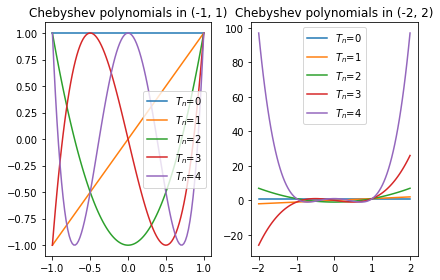

In [6]:
plt.subplot(1, 2, 1)
x = np.linspace(-1, 1, 100)
for n in range(5):
    plt.plot(x, plt.np.polynomial.Chebyshev.basis(n)(x), label=f'$T_n$={n}')
plt.title('Chebyshev polynomials in (-1, 1)')
plt.legend();
plt.subplot(1, 2, 2)
x = np.linspace(-2, 2, 100)
for n in range(5):
    plt.plot(x, plt.np.polynomial.Chebyshev.basis(n)(x), label=f'$T_n$={n}')
plt.title('Chebyshev polynomials in (-2, 2)')
plt.legend();
plt.tight_layout()

Is it just me, or the Chebyshev polynomials actually look quite a lot like $sin$ and $cos$ functions in $(-1,1)$ (left fig)? Note that they are also bounded there, and that they quickly blow up outside $(-1, 1)$ (right fig).

Now, as any respactable functional basis they have the property that an arbitrary reasonable function $f(x)$ can be expanded into the Chebyshev series
$$f(x)=\sum_{n\ge0} a_nT_n(x), \qquad x\in (-1, 1)$$
with decaying coefficients $a_n$. One can bound $a_n$ as follows @Tang2023
$$a_n\le 2M\rho^{-n} \ .$$

Parameters $M$ and $\rho$ need to be explained. Define the Bernstein ellipse $E_{\rho}$ as the set of poins on the complex plain that are bounded by the ellipse $\frac{z+z^{-1}}{2}, |z|=\rho$, or alternatively $\frac{\rho e^{i\phi}+\rho^{-1} e^{-i\phi}}{2},\phi\in (0,2\pi)$. Note that $\rho>1$ and the interval $(-1,1)$ is contained in $E_\rho$. Here is a sketch.

![](figures/ellipse.svg){width=400 fig-align='center'}

Now, assume that $f(x)$ can be analytically continued from $(-1,1)$ to the interior of $E_\rho$ and. Then, $M$ the upper bound on the value of $f(z)$, i.e. $|f(z)|<M, z\in E_\rho$. Alright, so for any fixed $M$ and $\rho$ the Chebyshev coefficients of $f(x)$ decay exponentially. Given this fact and that all Chebyshev polynomials are bounded by 1 on $x\in(-1,1)$ we find that truncation of the Chebyshev expansion satisfies
$$|f(x)-\sum_{m=0}^n a_m T_m(x)|\le \frac{2M\rho^{-n-1}}{\rho-1} \ . $$

This approximation result is in general not sufficient for QSVT applications. The interval $(-1,1)$ here should be really thought of as the interval $(a,b)$ from the previous section, i.e. the subset where the target function needs to be approximated. This means that along with finding a good approximation on $(-1,1)$ we also need to ensure that the resulting polynomial remains bounded in some region outside $(-1,1)$, which is an additional challenge.

## A recipie for building bounded Chebyshev approximations {#sec-polynomial_how_to}
A general workaround for this problem is proposed in @Tang2023. The idea is to take an approximation that behaves well on $(-1,1)$ but blows up outside, and multiply it by a function that is close to 1 at $(-1, 1)$ and rapidly decays outside. Then the product can be re-expanded in the Chebyshev basis and yield the desired result. Here is the summary of the procedure (Theorem 19 of  @Tang2023).

Let $f(x)$ be analytic on $[-1, 1]$ and analytically continuanable to $E_\rho$ where it is bounded by $M$. Denote $\rho=1+\alpha, \alpha>0$. For any $\epsilon$ there is a polynomial $p(x)$ such that

1. $|f(x)-p(x)|_{[-1,1]}\le M\epsilon$. 
1. $|p(x)|_{[-1-\delta, 1+\delta]}\le M$.
1. $|p(x)|_{[-b,-1-\delta]\cup [1+\delta, b]}\le M\epsilon$.

In words, $p(x)$ approximates $f(x)$ to relative precision $\epsilon$ on $[-1,1]$. Furthermore, $p(x)$ is bounded by a constant in some $\delta$-neighborhood outside $[-1, 1]$. Finally, $p(x)$ is $\epsilon$-close to zero outside this $\delta$-neighborhood and up to a larger $b$-neighborhood. Here is a sketch.

![](figures/approx_delta.svg){width=400 fig-align='center}

The condition that $p(x)$ is zero ouside some $\delta$-neighborhood is useful for approximating piece-wise smooth functions. Now, I haven't yet told what are $\delta, b$ and, most importantly, what is the degree of the polynomial? According to @Tang2023, $\delta$ can be anywhere in $(0, \frac{min(1,\alpha^2)}{C})$ for a sufficiently large but constant $C$. You can choose $b>1+\delta$ freely. Then, the desired polynomial has degree
\begin{align}
\operatorname{deg}p(x)=O\left(\frac{b}{\delta}\log \frac{b}{\delta \epsilon}\right) \label{pdeg} \ .
\end{align}

Some important features of this formula
1. If you insist on a good approximation at the point of discontinuity, you pay linear price. I.e. the degree of the polynomial scales linearly (modulo log factor) with $\delta^{-1}$.
1. If you want your polynomial approximation to be bounde far enough away from $[-1,1]$ you pay linear price, i.e. the degree scales linearly with $b$.
1. Dependence on the error is logarithmic, which is nice.

## Illustration: approximating the step function {#sec-theta_approx}
In many applications of QSVT it is actually very helpful to approximate the step function $\theta(x-a)$ for some small $a$. This will also help us illustrate the approximation results described above. 

A problem with this step function is that it is not of definite parity, so we will instead aim to approximate its odd part $f(x)=\frac12\left(\theta(x-a)+\theta(-x-a)\right)$. The two parts of this piecewise-smooth function are just constants $\pm1$, and hence $M=1$ for arbitrary $\rho$. The only thing we need to take care of is that the discontinuity region, where our approximation fails, is small enough $\delta\le a$. This implies that there is a polynomial of degree $O(\frac1a\log\frac1{a\epsilon})$ that does the job.

In this case and some other cases the approximation bound stated in the previous section does not give the tighest result. For instance, approximating the step function is possible with a polynomial of degree $O(\frac1a\log\frac1\epsilon)$, i.e. the additional $\log\frac1{a}$ factor is not necessary. The overhead we get from applying the procedure above is often modest, a may be a good price to pay for the universality of the approach.

# QSVT

Phew! That was quite a bit of preparing. However, we now have all the ingredients in place to explain how (and also a bit why) QSVT works.

## Recap
Let's recap what is the setup.

1. The goal is to perform a functional transformation on the singular values of some operator $A\to f(A)$.
1. We are provided with a unitary $U$ that block encodes $A$, i.e. $U=B_L\begin{pmatrix} A&*\\*&*\end{pmatrix}B_R^\dagger$ (in many cases of interest $B_L=B_R=\mathbb{1}$).
1. We are provided with projectors $\Pi_L,\Pi_R$ that describe this block encoding, i.e. $\Pi_L U \Pi_R=B_L\begin{pmatrix} A&0\\0&0\end{pmatrix}B_R^\dagger$ and can perform projector rotations $\Pi_L(\phi), \Pi_R(\phi)$.
1. We figured out what is a good polynomial approximation to our target function $p(x)\approx f(x)$.

From these ingredients, the QSVT builds a unitary $U_\phi$ that block encodes the desired polynomial transformation.

## ow QSVT works
Alright, how to build $U_\phi$? A bit awkwardly, we will have to separately describe two cases, when $p(x)$ is even and when it is odd. So, for $p(x)$ even (the number of QSP phases is odd)

\begin{align}
U_\phi = \left(\prod_{i=0}^{d/2-1}\Pi_R(\phi_{2i})U^\dagger\Pi_L(\phi_{2i+1})U \right) \Pi_R(\phi_d),\qquad U_\phi=B_R\begin{pmatrix}p(A) & *\\ * & *\end{pmatrix} B_R^\dagger\ . \label{QSVT even}
\end{align}

For $p(x)$ odd (the number of QSP phases even)
\begin{align}
U_{\phi}=\Pi_L(\phi_{0})U\prod_{i=1}^{(d-1)/2}\Pi_R(\phi_{2i-1})U^\dagger\Pi_L(\phi_{2i})U \Pi_R(\phi_d),\qquad U_\phi=B_L\begin{pmatrix}p(A) & *\\ * & *\end{pmatrix} B_R^\dagger \label{QSVT odd}
\end{align} 

Recall that we defined polynomial of a matrix $p(A)$ in @sec-polymatrix, and that it had the same personality split into even/odd cases. The angles $\phi$ are *the same* angles that we would use to apply $p(x)$ in QSP with R-conventions. 

:::{.callout-note}
One thing I tripped over. In QSP, we have different signal conventions and need to use a different angle sequence for each. Now I just told you that for QSVT we need to borrow QSP angles in the R-convention. Don't we need to specify how exactly is our operator $A$ block encoded in $U$ then? No, we need not. The difference between QSP and QSVT is that in QSP we apply the same signal operator throughout, while in QSVT we alternate between $U$ and $U^\dagger$. Because different block encodings are related by unitary transformations, these differences cancel in the QSVT sequence. To see why the R-convention of QSP most naturally maps to QSVT, take a look at the next section.

:::

## QSVT circuit

Draw QSVT circuit. Explain that projects are not general. Explain that we will not draw circuits in implementation. Explain how to get controlled version of a circuit.

Let's implement the QSVT circuit in code for later use.

In [4]:
def projector_rotation(P, phi):
    """Computes exponential of a projector using relation e^{i (2P-1) x}= cos(x)+i(2P-1)sin(x)"""
    N = len(P)
    return np.eye(N)*np.cos(phi)+1j*(2*P-np.eye(N))*np.sin(phi)


def apply_QSVT(U, PL, PR, phis):
    
    phi_last = phis[-1]
    
    if len(phis) % 2 == 1: # Even polynomial
        phis_paired = phis[:-1]
        phi_0 = None
    else: # Odd polynomial
        phis_paired = phis[1:-1]
        phi_0 = phis[0]
    
    res = projector_rotation(PR, phi_last)
    
    for phi_R, phi_L in np.array(phis_paired).reshape(-1, 2)[::-1]:
        res =  projector_rotation(PR, phi_R) @ U.conj().T @  projector_rotation(PL, phi_L) @ U @ res
    
    if phi_0 is not None:
        res = projector_rotation(PL, phi_0) @ U @ res
        
    return res

## Why QSVT works
Alright, how do we prove \eqref{QSVT even} and \eqref{QSVT odd}? I'd say that the full proof is a bit tedious and not very illuminating, but we can get a good intuition by looking at several particular cases. I will follow a recent exposition in @Tang2023 that simplifies the derivation. The key idea there is to leverage another special matrix decomposition, known as the ***CS decomposition*** (cosine-sine). It states that for any unitary matrix $U$ consisting of four blocks the following holds
$$U=\begin{pmatrix}U_{00} & U_{01} \\ U_{10} & U_{11}\end{pmatrix}=\begin{pmatrix}V_0 & 0 \\ 0 & V_1\end{pmatrix}\begin{pmatrix}C & S \\ S & -C\end{pmatrix}\begin{pmatrix}W_0 & 0 \\ 0 & W_1\end{pmatrix}^\dagger \ .$$

here $V_{0}, V_{1}, W_{0},W_{1}$ are unitaries of an appropriate sizes. If all blocks in $U$ are of equal size, matrices $C$ and $S$ are diagonal and satisfy $C^2+S^2=\mathbb{1}$, hence the name CS. For block of arbitrary sizes there will still be CS-sublocks, but you'd also have to carefully pad them with zeros and ones. I will not consider this case here.

Important property of the CS-decomposition, which is not shared e.g. by the SVD, is that the unitaries sandwiching the CS-core are block-diagonal. For this reason, they commute through projector-rotations and effectively drop out of the QSVT sequence. At the same time, the middle matrix in CS-decomposition looks exactly as the R-signal matrix in QSP, which explains why we need to use QSP angles in R-convention to build QSVT circuit.

With these ideas in place, the rest is mostly filling in the details. I will not do this here, but you are welcome to try and work out the full derivation or look in up in @Tang2023.

## Qubitization

QSVT is closely related to a concept of ***qubitization***, which I believe was introduced a bit earlier in the context of Hamiltonian simulation. The idea was again to adopt QSP to high-dimensional systems. I you go through the derivations in the previous section, you will note that you never have to deal with anything but $2\times2$ block matrices. So effectively, the problem was indeed reduced to a QSP of a two-level system. In jargon, we have qubitized the problem.

Alright, we are now ready to tackle the applications of QSVT.

# Grover's search

As is standard, I will open the list of QSVT applications with Grover's search. I must note though that I find it to be conceptually a bit harder than many other applications. This is because we will deal with a block encoding in an apriori unknown basis, which is unusual. Anyway, let's get going.

## The problem

We aim to find an unknown computational basis state $|m\rangle$. As our signal unitary we choose the Hadamard gate acting on all qubits $U=H^{\otimes n}$. We know that $\langle m|H^{\otimes n}|0\rangle=\frac{1}{\sqrt{N}}$. In other words, 

$$U = \frac{1}{\sqrt{N}} |m\rangle\langle 0|+\dots \ ,$$

i.e. in a suitable basis, $U$ block encodes the transition amplitude between $|0\rangle$ and $|m\rangle$. If we could apply a polynomial transformation, which approximates $\theta(x-a)$ with $a<\frac{1}{\sqrt{N}}$, we would effectively amplify the transition amplitude and construct a unitary $U_\phi$ that is almost guaranteed to prepare our marked state $|m\rangle$ starting with $|0\rangle$.

A difficulty is that we do not really know the basis of the block encoding, as this would be equivalent to knowing $|m\rangle$. At the sime time, in QSVT we only need to access controlled versions of projectors corresponding to the block encoding, and this is exactly what Grover's oracle does.

## Projectors
Grover's oracle can be defined as $G=\mathbb{1}-2|m\rangle\langle m|$. Actually, in practical applications Grover's oracle is more often represented as an operator that flips the state of an auxilary qubit controlled by the state of the system, i.e. $G|n\rangle|0\rangle=|n\rangle|0\rangle$ for $n\neq m$ and $G|m\rangle|0\rangle=|m\rangle|1\rangle$. In effect, this operator is nothing but the $|m\rangle$-controlled NOT gate $G=C_{|m\rangle\langle m|}NOT$. As we discussed in @sec-projector_rotations it is sufficient to construct the projector rotation $\Pi_R(\phi)$. The left projector is simply $\Pi_L=|0\rangle\langle0|$ and its controlled version is just the $n+1$ qubit Toffoli gate.

## Polynomial approximation
So we aim to approximate $\theta(x-a)$ for $a\le \frac1{\sqrt{N}}$. As discussed in @sec-theta_approx, this can be done using a polynomial of degree $O(\frac{1}{a}\log\frac{1}{a\epsilon})=O(\sqrt{N}\log\frac{\sqrt{N}}{\epsilon})$. We know that Grover's search can run in time $\sqrt{N}$ so the extra $\log\sqrt{N}$, while not crucial, is unnecessary. Anyway, in the framework of QSVT finding a better scaling algorithm amounts to 'just' constructing a more efficient polynomial approximation. We won't go there.

Actually, I will not construct the polynomial approximations at all in subsequent implementation. Instead, I will use routines provided by `pyqsp` that besides building a QSP sequence from a polynomial also includes the approximation utils.

## Implementation

First let's define and look at the approximating polynomials. To build them, we will need to use a function provided by `pyqsp` package, which approximates $erf(-\delta x)$. Apparently, we can not simply specify the desired precision here, but instead have to give the degree of the polynomial and $\delta$. I will go with the simplest options $\operatorname{deg}p=\sqrt{N}, \delta=\sqrt{N}$ which give a decent, but not ideal performance.

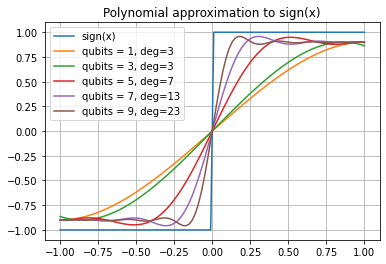

In [8]:
def sign_approximating_polynomial(num_qubits):
    """Polynomial that approximates the step function theta(x) for x>= 1/N**0.5"""
    
    N = 2**num_qubits
    target_function = pyqsp.poly.PolySign()
    
    # For the Sign `pyqsp` does not determined the degree of the polynomial.
    # We have to input it. I will take the closest odd number to N**0.5
    
    degree = np.ceil(N**0.5)
    if degree % 2 == 0:
        degree += 1
    
    # This delta controls the width of our approximation around zero, but does not exacly
    # correspond to delta defined in the text, rather delta here ~ 1 / our delta.
    delta = N**0.5
    
    # Find the polynomial approximation.
    p =  quiet(target_function.generate)(degree, delta=delta)
    
    return p

x = np.linspace(-1, 1, 100)
plt.plot(x, np.sign(x), label='sign(x)')

for num_qubits in range(1, 11, 2):
    p = sign_approximating_polynomial(num_qubits)
    plt.plot(x, p(x), label=f'qubits = {num_qubits}, deg={p.degree()}')

plt.grid()
plt.legend();
plt.title('Polynomial approximation to sign(x)');

We see that indeed, as we increase the degree of the polynomial, the approximation around $x=0$ impoves.
Now we are ready to peform full Grover's serach by QSVT.

In [9]:
np.random.seed(42)

def projector_from_state(state):
    """Builds |n><n| from |n>."""
    
    return np.outer(state, state.conj())


qubits = range(1, 11)
amplitudes = []

for num_qubits in qubits:
    
    N = 2**num_qubits
    
    # Define initial state |0> and the associated projector.
    all_zero_state = np.zeros(N)
    all_zero_state[0] = 1
    PR = projector_from_state(all_zero_state)

    # Define a random marked state |m>. It will only be accessed via the corresponding projector.
    marked_state = np.zeros(N)
    marked_state[np.random.randint(0, N)] = 1
    PL = projector_from_state(marked_state)

    # Signal operator is the n-th tensor power of the Hadamard gate.
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    U = reduce(np.kron, [H]*num_qubits)

    # We will approximate the step function.
    p = sign_approximating_polynomial(num_qubits)
    
    # Determine QSP angles
    phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
    phis = angles_from_W_to_R(phis)
    
    # Construct the QSVT sequence
    U_phi = apply_QSVT(U, PL, PR, phis)
    
    # Determine the overlap with the marked state.
    # Recall that takind the real part corresponds to combining two QSVT sequence and is not exactly trivial
    # at the level of circuits.
    amplitude = np.real(marked_state @ U_phi @ all_zero_state)
    
    amplitudes.append(amplitude)

Alright, here is the result.

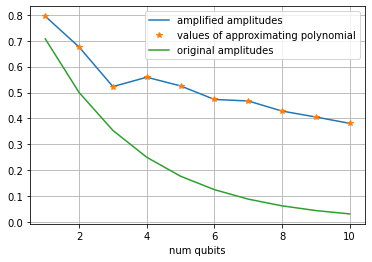

In [10]:
original_amplitudes = 2**(-0.5*np.array(qubits))
polynomial_values = [sign_approximating_polynomial(n)(a) for n, a in zip(qubits, original_amplitudes)]

plt.plot(qubits, amplitudes, label='amplified amplitudes')
plt.plot(qubits, polynomial_values, '*', label='values of approximating polynomial')
plt.plot(qubits, [2**(-0.5*q) for q in qubits], label='original amplitudes')

plt.xlabel('num qubits')
plt.grid();
plt.legend();

We see that with our algorithm indeed significantly amplifies the original amplitudes with only $\sqrt{N}$ calls to Grover's oracle, albeit not perfectly. Ideally, the amplified amplitudes stay constant as $N$ increases, while ours decay. However, this is entirely due to our choice of the polynomial approximation, which is demonstrated by plotting the values of the approximating polynomial. So our QSVT circuit works just as expected, but our approximating polynomials could be improved. I will not attempt to do it here.

# Hamiltonian simulation
 
Hamiltonian simulation lands itself very naturally to the QSVT framework, although there are some technical details to watch out for. Let's begin.

## The problem
The task is, given a Hamiltonian $H$, build a unitary $e^{-iHt}$. That's it. So we need just need to figure out how to apply $f(x)=e^{-ixt}$ with QSVT. 

## Watch out for your Hamiltonian
Except that there may be subtleties. First, if $||H||>1$ we could only block encode $H/\alpha$ with large enough $\alpha$. But that's fine, because simulating $H$ for time $t$ is the same as simulating $H/\alpha$ for time $\alpha t$. Next, if $H$ have negative eigenvalues, these do not coincide with the singular values. One way to deal with that is to shift $H$ by a constant $H+\alpha$, which can be achieved using the linear combination of unitaries. I will proceed assuming that $||H||\le 1$ and $H\ge0$.

## Solving the parity problem
Exponential $e^{-ixt}$ is not of definite parity, so we will need to construct it even and odd parts separately, and then combine into a linear combination of unitaries using the following circuit.

![](figures/cossin.svg){width=300 fig-align='center'}

:::{.callout-note title="Exercise"}
Try to guess which $H$ is the Hadamard gate and which is the Hamiltonian.
:::

In fact, this circuit will block encode $\frac12 e^{-iHt}$. Since for any $|\psi\rangle$ we have $|\frac12 e^{-iHt}|\psi\rangle|^2=\frac14$ the algorithm will succeed with a constant probability $\frac14$.

## Approximating polynomial

So now the task is to approximate $\cos xt$ and $\sin x t$ on $[0, 1]$ to some precision $\epsilon$. How should the result scale with $t, \epsilon$? Let's try to apply procedure from @sec-polynomial_how_to. Since this procedure does not require a definite parity we will look at $f(x)=e^{-ixt}$. First we need to linearly map the region where we want the approximation $[0,1]$ to the standard domain of Chebyshev polynomials $[-1,1]$. We do this via $y=2x-1 \to x=\frac{y+1}{2}$. Then we look at $f(x(y))=e^{-i\frac{y+1}{2}t}$. In the Bernstein ellipse $E_\rho$ this function has the maximum absolute value $e^{\frac\alpha2 t}$, achieved when $y$ has the largest imaginary part $\operatorname{im} y=\frac{\rho-\rho^{-1}}{2}\approx \alpha$ assuming $\rho=1+\alpha, \alpha\ll1$. Therefore, by taking $\alpha=\frac{1}{t}$ we keep the target bounded by a constant in $E_\rho$ as we increase $t$. According to @sec-polynomial_approx, the smallest $\delta$ we can choose is $\delta=\alpha^2=\frac{1}{t^2}$ which gives the approximating polynomial of degree $O(t^2\log t^2/\epsilon)$. While not terrible, this is quite suboptimal. Even on physical grounds, we expect that the complexity of the simulation problem should scale lineraly with $t$, not quadratically. A better approximation can be obtained by direct truncation of the Chebyshev series for $e^{-ixt}$ and gives a polynomial approximation with degree scaling as $t+\frac{\log \epsilon^{-1}}{\log(e+t^{-1}\log\epsilon^{-1})}$. I agree, this looks sort of weird, but for fixed $\epsilon$ and large enough $t$ scaling is linear in $t$. I will not dig into details of how to derive this approximation, but you can look them up in @Tang2023 or @Martyn2021. Anyway, we are going to use the approximating polynomials determined by `pyqsp`.

## Implementation

First let's define a class that will take an artibrary matrix $A, ||A||\le1$ and block encode it into a minimum number of qubits possible. We will use it here and in the next section.

In [5]:
#| code-fold: true

class BlockEncoding:
    
    def __init__(self, M):
        
        self.num_rows = M.shape[0]
        self.num_cols = M.shape[1]
        self.dim = 2*self.block_dimension(max(self.num_cols, self.num_rows))
        
        self.diagonal_block = self.pad_matrix(M, self.dim//2)
        
        U, S, WH = np.linalg.svd(self.diagonal_block)
        
        self.U = U
        self.S = S
        self.WH = WH
        
        self.off_diagonal_block = self.make_off_diagonal_block(self.U, self.S, self.WH)
        
        self.unitary = self.unitary_from_blocks(
            self.diagonal_block, 
            self.off_diagonal_block)
        
        self.projector = np.kron(np.diag([1, 0]), np.eye(self.dim//2))
 
    @staticmethod
    def block_dimension(n):
        """Finds the minimum number of qubits to block encode a square matrix of dimension n"""
        return int(2**np.ceil(np.log2(n)))
        
    @staticmethod
    def pad_matrix(M, dim):
        """Pads a matrix with zeros make to make it into a d x d matrix.."""
        
        S = np.zeros((dim, dim), dtype=np.complex64)
        n_rows, n_cols = M.shape
        S[:n_rows,:n_cols] = M
        return S
    
    @staticmethod
    def make_off_diagonal_block(u, s, wh):
        assert np.all(s<=1), f'All singular values {s} must be less than 1.'
        return u @ np.diag(np.sqrt(1-s**2)) @ wh
    
    @staticmethod
    def unitary_from_blocks(A, B):
        n = A.shape[0]
        U = np.zeros((2*n, 2*n), dtype=np.complex64)
        U[:n, :n] = A
        U[:n,n:2*n] = B
        U[n:2*n, :n] = B
        U[n:2*n, n:2*n] = -A
        
        assert np.allclose(U @ U.conj().T, np.eye(2*n), atol=1e-5), 'Ops, block encoding is not unitary.'
        return U

Now let's build and look at approximating polynomials. In contrast to the sign function we used in Grover's algorithm, here we can directly specify the desired time and accuracy, and the degree of the polynmial is determined by the package.

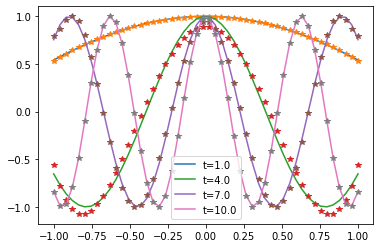

In [12]:
def trig_approximating_polynomial(t, epsilon, func):
    
    
    if func == 'cos':
        target_function = pyqsp.poly.PolyCosineTX()
    elif func == 'sin':
        target_function = pyqsp.poly.PolySineTX()
    else:
        raise ValueError
        
    coeffs = quiet(target_function.generate)(tau=t, epsilon=epsilon)
    
    return np.polynomial.Polynomial(coeffs)

epsilon = 0.5
t = np.linspace(1, 10, 4)
x = np.linspace(-1, 1, 50)

for ti in t:
    plt.plot(x, np.cos(x*ti), label=f't={ti}')
    plt.plot(x, 2*trig_approximating_polynomial(ti, epsilon, 'cos')(x), '*')

plt.legend();

We see that our polynomials (plotted by stars) match the trigonometric functions well. So let's go ahead and implement the whole QSVT circuit. In Grover's example we looked how the results scale with the system size, here we instead will look at scaling with time.

In [13]:
seed = 42
np.random.seed(seed)

# Fix the system size. The scalings should be independent.
num_qubits = 6
N = 2**num_qubits

# Generate a random Hamiltonian satisfying H>0, and ||H||<1 
V = scipy.stats.unitary_group.rvs(N, random_state=seed)
D = np.random.uniform(low=0, high=1, size=(N,))

H = V*D @ V.conj().T

# Block encode the Hamiltonian.
block_encoding = BlockEncoding(H)
U = block_encoding.unitary
P = block_encoding.projector

# Parameters.
t = np.arange(1, 10)
epsilon = 0.01

# We will keep track of the approximation quality and degrees of approximating polynomials.
accuracies = []
degrees = []

for ti in t:

    U_phi = []
    total_degree = 0
    
    # Construct QSVT circuits for the cos and sin part separately.
    # Keep track of the total degree.
    for target_function in ['cos', 'sin']:
        p = trig_approximating_polynomial(ti, epsilon, target_function)
        phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
        phis = angles_from_W_to_R(phis)
        
        total_degree += len(phis)-1

        U_phi.append(apply_QSVT(U, P, P, phis))
    
    degrees.append(total_degree)
    
    # Unpack constructed sequences.
    U_phi_cos, U_phi_sin = U_phi
    
    # Select real parts of the singular values.
    # This is not a trivial operation at circuit level.
    H_cos = U_phi_cos[:N, :N]+U_phi_cos[:N, :N].conj().T
    H_sin = U_phi_sin[:N, :N]+U_phi_sin[:N, :N].conj().T
    
    # Assemble even and odd parts into an exponential.
    # Again, not trivial at the circuit level.
    H_transformed = H_cos -1j*H_sin
    
    # Quantify accuracy of the result by the operator norm wrt exact anser.
    accuracy = np.linalg.norm(H_transformed-scipy.linalg.expm(-1j*H*ti), ord=2) # ord=2 == operator norm
    accuracies.append(accuracy)

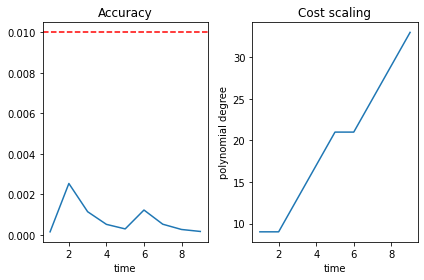

In [14]:
plt.subplot(1, 2, 1)
plt.plot(t, accuracies)
plt.axhline(epsilon, color='red', linestyle='--')
plt.xlabel('time')
plt.title('Accuracy');

plt.subplot(1, 2, 2)
plt.plot(t, degrees)
plt.xlabel('time')
plt.ylabel('polynomial degree')
plt.title('Cost scaling');

plt.tight_layout()

Alright, so at least in the range we have chosen the error remains below the threshold while the degree of the polynomial appears to scale linearly with $t$. 

# Solving linear systems
Our final example will be a linear system solver. Let's begin at the beginning.

## The problem
Given a linear system $Ax=b$ we aim to compute $A^+b$ where $A^+$ is the Moore-Penrose pseudo-inverse, see @sec-pseudo_inverse. Again, framing the problem in QSVT terms is rather trivial, we only need to apply $f(x)=\frac1x$ to the singular values of $A^\dagger$.

## Watch out for your linear system
If the original operator $A$ can be block embedded all its singular values satisfy $\sigma_i\le1$ (if this is not so, we should block embed $A/\alpha$ instead, similarly to the Hamiltonian simulation case). But then $1/\sigma_i$ will necessarily be greater than 1 and so $A^+$ could not be block embeded into a unitary. Moreover, the function $\frac1x$ blows up at $x=0$ and there is no hope to approximate it with a polynomial. Both there problems hint that we need to make an assumption on the range of singular values.

We will assume that $\frac{1}{\kappa}\le\sigma_i\le1$. Then $\kappa$ is known as the condition number of the system. It is an important figure of merit for classical sovlers as well. Now we can make the problem well-posed. The goal is to approximate $f(x)=\frac{1}{2\kappa x}$ for $x\in[\frac{1}{\kappa}, 1]$ (the additional factor $\frac12$ is just to make sure $|f(x)|<1$ in the desired range).

## Approximating polynomial
Alright, how do we expect the complexity of the algorithm to scale with $\kappa, \epsilon$? 

Let's quickly run the procedure of @sec-polynomial_how_to. First make a linear transformation $y=\frac{2x-1-\kappa^{-1}}{1-\kappa^{-1}}$ that maps $[\kappa{^-1},1]$ to $[-1,1]$. We get
$$f(x(y))=\frac{\frac1{\kappa+1}}{y+\frac{\kappa+1}{\kappa-1}}$$

This function has a pole at $y=-\frac{\kappa+1}{\kappa-1}$ and is maximazed in the Bernstein ellipse when $y$ approaches this pole along the real axis. For $y\ge-1-\frac{1}{k+1}$ we can write $|f(x(y))|<1$ Therfore, $f(x(y))$ is bounded by $1$ in a Bernnstein ellipse $E_\rho$ of radius $\rho=1+\alpha$ with $\alpha^2=\frac{2}{\kappa+1}$. Therofore, we can choose $\delta\sim\frac{1}{\kappa}$. Note that $y(-1)=-3+O(\kappa{-1})$ and so we can choose $b=2$, this does not affect the complexity. Therefore, in this case we expect the degree of the approximating polynomial to scale as
$$\operatorname{deg}p=O(\kappa\log \frac{\kappa}{\epsilon} )\ .$$

A couple of quick commets. 
- This scaling is a significant improvement to the original HHL algorithm, which  runs in $O(\frac{\kappa^2\log N}{\epsilon})$. Apparently, this scaling is state-of-the-art result for quantum matrix inversion.
- The matrix dimension $N$ does not enter our scaling explicitly. However, if the costs of block encoding $A$ are taken into account the result will likly scale with $N$.
- Merely finding $A^{+}$ is not a end-to-end quantum algorithm. In practice, you would also need a way to load the vector $|b\rangle$ in and be able to read out useful information from a quantum state $|A^{+}b\rangle$, which are no trivial considerations.
- The post-selection probability to get $|A^+b\rangle$ is proportional to $|\frac{1}{2\kappa}A^+b|^2\ge \frac{1}{4\kappa^2}||A^+||^2\ge \frac{1}{4\kappa^2}$. It decays quadratically with $\kappa$ but can be expnentially enhanced via a classical repetition or a quantum amplitude amplification.


## Implementation
Alright, let's inmplement our final example. First let's build and look at approximating polynomials.

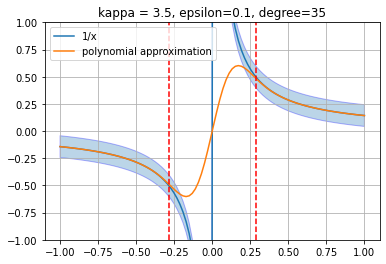

In [79]:
def xinverse_approximating_polynomial(kappa, epsilon):
    """Polynomal approxiamtion to 1/(2*kappa*x)"""
    
    target_function = pyqsp.poly.PolyOneOverX()
    coeffs, scale = quiet(target_function.generate)(kappa=kappa, epsilon=epsilon, return_scale=True)
    
    # For some reason, pyqsp returns 1/x*scale with some `scale`
    # that might be different from 1/kappa. 
    # We remove this scale from our polynomial.
    
    return np.polynomial.Polynomial(coeffs/(scale*2*kappa))


epsilon = 0.1
kappa = 3.5

x = np.linspace(-1, 1, 100)
plt.ylim(-1, 1)

plt.plot(x, 1/(2*kappa*x), label='1/x')
plt.fill_between(x, 1/(2*kappa*x)+epsilon, 1/(2*kappa*x)-epsilon, alpha=0.3, edgecolor='b')
p = xinverse_approximating_polynomial(kappa, epsilon)
plt.plot(x, p(x), label='polynomial approximation')

plt.axvline(1/kappa, ls='--', c='r')
plt.axvline(-1/kappa, ls='--', c='r')

plt.grid()
plt.legend();
plt.title(f'kappa = {kappa}, epsilon={epsilon}, degree={p.degree()}');

This seems right. Let's also write a function to generate random linear sysmtes with matrices $A$ satisfying $A\in \mathbb{R}, ||A||\le1$. It's nothing interesting, really.

In [80]:
#| code-fold: true

def random_A(kappa, num_qubits):
    """Construnct a random real operator A with ||A||<1 and condition number <= kappa.
        Size of A is n by m, which a both smaller than 2**num_qubits."""

    N = 2**num_qubits

    n, m = np.random.randint(N//2, N, size=2)  # Lets make N>= n,m >= N/2
    V = scipy.stats.ortho_group.rvs(n, random_state=seed**2)
    W = scipy.stats.ortho_group.rvs(m, random_state=seed**3)

    singular_values = np.random.uniform(low=1/kappa, high=1, size=min(n, m))
    Sigma = np.zeros((n, m))
    Sigma[:min(n, m), :min(n, m)] = np.diag(singular_values)

    A = V @ Sigma @ W.conj().T
    
    
    return A

Now we are ready to proceed with the full-fledged QSVT application. This time we will look at how complexity scales with $\kappa$. This scaling should be independent of other parameters.

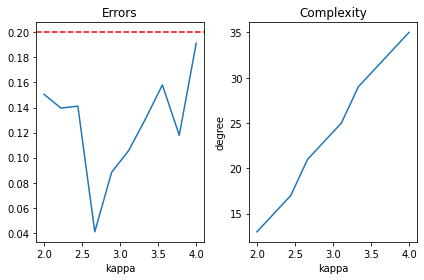

In [91]:
seed = 1
np.random.seed(seed)

num_qubits = 5
N = 2**num_qubits

epsilon = 0.2
kappas = np.linspace(2, 4, 10)

# We will keep track of accuracies and polynomial degrees.
errors = []
degrees = []

for kappa in kappas:

    # Generate a random linear system.
    A = random_A(kappa, num_qubits)
    n, m = A.shape

    # Block encode it.
    block_encoding = BlockEncoding(A)
    U = block_encoding.unitary
    P = block_encoding.projector
    
    # Determine approximating polynomial and QSP angles.
    p = xinverse_approximating_polynomial(kappa, epsilon)
    degrees.append(p.degree())
    
    phis = pyqsp.angle_sequence.QuantumSignalProcessingPhases(p.coef, signal_operator='Wx')
    phis = angles_from_W_to_R(phis)
    
    # The QSVT circuit itself.
    U_phi = apply_QSVT(U, P, P, phis)
    
    # Compare with the exact pseudo-inverse via the operator norm.
    exact_pseudo_inverse = np.linalg.pinv(A)
    our_pseudo_inverse = 2*kappa*np.real(U_phi.conj().T)[:m, :n] 
    
    error = np.linalg.norm(our_pseudo_inverse-exact_pseudo_inverse, ord=2)
    errors.append(error)
    
plt.subplot(1, 2, 1)
plt.plot(kappas, errors)
plt.title('Errors');
plt.xlabel('kappa');
plt.axhline(epsilon, linestyle='--', c='r')
plt.subplot(1, 2, 2)
plt.plot(kappas, degrees)
plt.title('Complexity');
plt.ylabel('degree');
plt.xlabel('kappa');
plt.tight_layout()

This looks right, the error quanitified by the operator norm stays below the threshold while the degree of the approximating polynomial seems to grow linearly. This wraps up the experiment.

# Conclusion

Come on, this post is already waay to long. The best I can do I can do is to skip the conclusion 😎. As always, feedback is highly appreciated.